In [109]:
import pandas as pd
import numpy as np
import json, csv, re
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

from nltk.corpus import stopwords

sns.set_style('darkgrid')
%matplotlib inline

# Dataframe

In [110]:
%%time
def to_list(entry):
  return list(json.loads(entry).values())

meta = pd.read_csv("./data/movie.metadata.tsv", sep = '\t', header = None)
meta.columns = [
    'id_wiki', 'id_freebase',
    "title", 'release date',
    'box office revenue', 'runtime',
    'languages', 'countries', 'genres']

meta['languages'] = meta['languages'].apply(to_list)
meta['countries'] = meta['countries'].apply(to_list)
meta['genres'] = meta['genres'].apply(to_list)

meta['languages'] = meta['languages'].apply(lambda x: np.nan if len(x)==0 else x)
meta['countries'] = meta['countries'].apply(lambda x: np.nan if len(x)==0 else x)
meta['genres'] = meta['genres'].apply(lambda x: np.nan if len(x)==0 else x)
meta.head()

CPU times: user 1.78 s, sys: 18.7 ms, total: 1.8 s
Wall time: 1.84 s


,id_wiki,id_freebase,title,release date,box office revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thriller]"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [111]:

plots = []
with open("./data/plot_summaries.txt", 'r') as f:
  reader = csv.reader(f, dialect='excel-tab')
  for row in tqdm(reader): # tqdm, A Fast, Extensible Progress Bar for Python and CLI
      plots.append(row)

id_wiki = []
plot = []

for i in tqdm(plots):
  id_wiki.append(i[0])
  plot.append(i[1])

plots = pd.DataFrame({'id_wiki': id_wiki, 'plot': plot})
plots.head()

42303it [00:01, 27593.47it/s]
100%|██████████| 42303/42303 [00:00<00:00, 992391.39it/s]


,id_wiki,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [112]:
meta['id_wiki'] = meta['id_wiki'].astype(str)
cols = ['id_wiki','title','plot','genres']

df = pd.merge(plots, meta[['id_wiki', 'title', 'genres']], on = 'id_wiki')
df.drop(df.loc[df['genres'].isna()].index, inplace=True)
df = df[cols]
df.head()

,id_wiki,title,plot,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.","[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...","[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...","[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [113]:
genres_flat = pd.Series([item for sublist in df.genres for item in sublist])
df_genres = genres_flat.groupby(genres_flat).size().rename_axis('Genre').reset_index(name='Count')
df_genres.sort_values('Count', ascending=False, ignore_index=True, inplace=True)
print('Generos Total: {}'.format(df_genres.shape[0]))
#df_genres.head(10)

Generos Total: 363


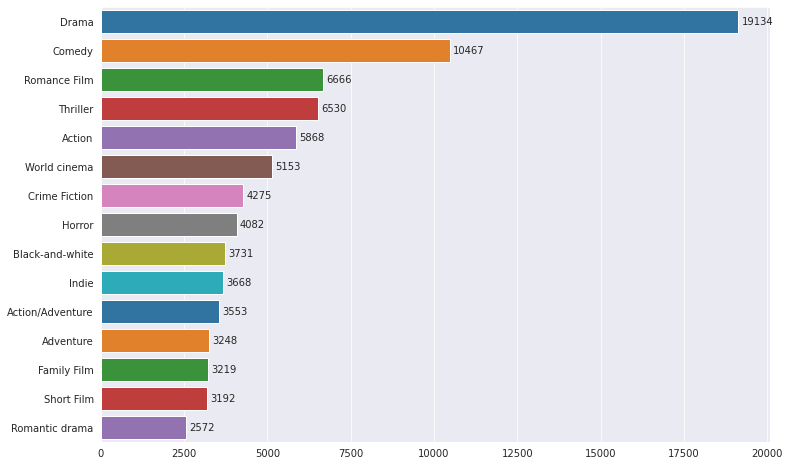

In [114]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_genres[:15], x='Count', y='Genre', palette='tab10')
ax.set(xlabel=None, ylabel=None)
ax.bar_label(ax.containers[0], padding=3)
plt.show()

# Pré-Processamento

## Normalização

> Normalization is the process of scaling individual samples to have unit norm.

In [117]:
df['plot_pre'] = np.nan
cols = ['id_wiki','title','plot','plot_pre','genres']
df = df[cols]

In [118]:
def normaliza(doc):
    doc = re.sub("\'", "", doc)
    doc = re.sub("[^a-zA-Z]"," ",doc)
    doc = ' '.join(doc.split())
    doc = doc.lower()
    return doc

%time df['plot_pre'] = df['plot'].apply(normaliza)
df.head()

CPU times: user 6.66 s, sys: 60.7 ms, total: 6.72 s
Wall time: 6.92 s


,id_wiki,title,plot,plot_pre,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",shlykov a hard working taxi driver and lyosha a saxophonist develop a bizarre love hate relationship and despite their prejudices realize they arent so different after all,"[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",the nation of panem consists of a wealthy capitol and twelve poorer districts as punishment for a past rebellion each district must provide a boy and girl between the ages of and selected by lottery for the annual hunger games the tributes must fight to the death in an arena the sole survivor is...,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",poovalli induchoodan is sentenced for six years prison life for murdering his classmate induchoodan the only son of justice maranchery karunakara menon was framed in the case by manapally madhavan nambiar and his crony dysp sankaranarayanan to take revenge on idealist judge menon who had earlier...,"[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",the lemon drop kid a new york city swindler is illegally touting horses at a florida racetrack after several successful hustles the kid comes across a beautiful but gullible woman intending to bet a lot of money the kid convinces her to switch her bet employing a prefabricated con unfortunately ...,"[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",seventh day adventist church pastor michael chamberlain his wife lindy their two sons and their nine week old daughter azaria are on a camping holiday in the outback with the baby sleeping in their tent the family is enjoying a barbecue with their fellow campers when a cry is heard lindy returns...,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


## Stopwords

> Stop words are any word in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text). There is no single universal list of stop words used by all natural language processing tools, nor any agreed upon rules for identifying stop words, and indeed not all tools even use such a list. Therefore, any group of words can be chosen as the stop words for a given purpose. The "general trend in [information retrieval] systems over time has been from standard use of quite large stop lists (200–300 terms) to very small stop lists (7–12 terms) to no stop list whatsoever"

In [119]:
stop_words = stopwords.words('english')

def remove_stopwords(doc):
    doc = doc.split()
    doc = [w for w in doc if not w in stop_words]
    doc = ' '.join(doc)
    return doc

%time df['plot_pre'] = df['plot_pre'].apply(remove_stopwords)
df.head()

CPU times: user 29.7 s, sys: 138 ms, total: 29.9 s
Wall time: 30 s


,id_wiki,title,plot,plot_pre,genres
0,23890098,Taxi Blues,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",shlykov hard working taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudices realize arent different,"[Drama, World cinema]"
1,31186339,The Hunger Games,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",nation panem consists wealthy capitol twelve poorer districts punishment past rebellion district must provide boy girl ages selected lottery annual hunger games tributes must fight death arena sole survivor rewarded fame wealth first reaping year old primrose everdeen chosen district older siste...,"[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,Narasimham,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",poovalli induchoodan sentenced six years prison life murdering classmate induchoodan son justice maranchery karunakara menon framed case manapally madhavan nambiar crony dysp sankaranarayanan take revenge idealist judge menon earlier given jail sentence manapally corruption case induchoodan achi...,"[Musical, Action, Drama, Bollywood]"
3,2231378,The Lemon Drop Kid,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",lemon drop kid new york city swindler illegally touting horses florida racetrack several successful hustles kid comes across beautiful gullible woman intending bet lot money kid convinces switch bet employing prefabricated con unfortunately kid woman belongs notorious gangster moose moran money ...,"[Screwball comedy, Comedy]"
4,595909,A Cry in the Dark,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",seventh day adventist church pastor michael chamberlain wife lindy two sons nine week old daughter azaria camping holiday outback baby sleeping tent family enjoying barbecue fellow campers cry heard lindy returns tent check azaria certain sees dingo something mouth running approaches discovers i...,"[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


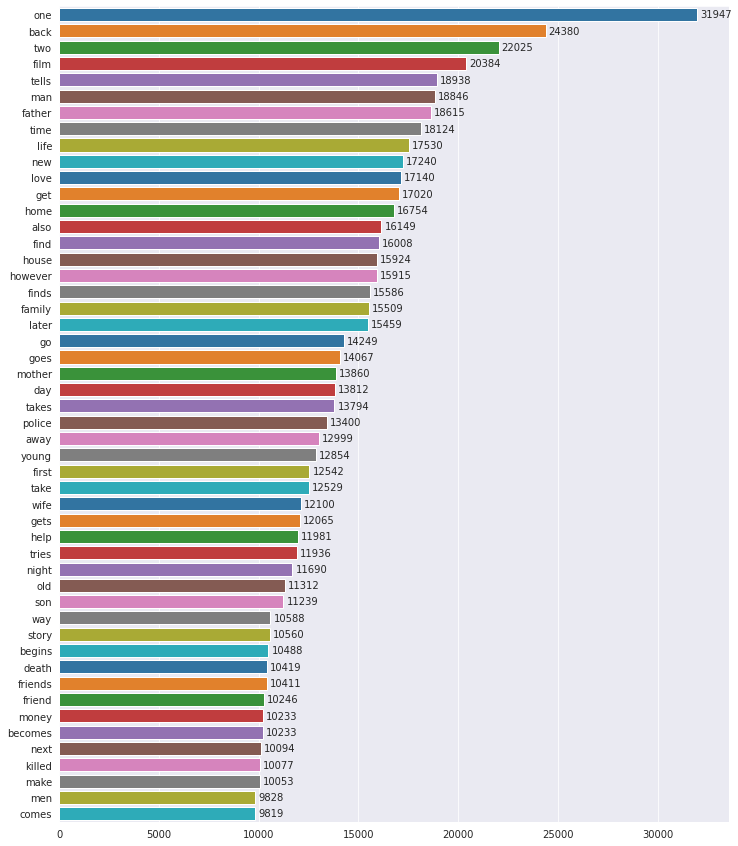

In [123]:
def words_freq(doc, terms=30): 
    li = ' '.join([text for text in doc])
    li = li.split() 
    freq = nltk.FreqDist(li) 
    df_words = pd.DataFrame({'word':list(freq.keys()), 'count':list(freq.values())})
    df_words.sort_values('count', ascending=False, ignore_index=True, inplace=True)

    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=df_words[:terms], x='count', y='word', palette='tab10')
    ax.set(xlabel=None, ylabel=None)
    ax.bar_label(ax.containers[0], padding=3)
    plt.show()

words_freq(df['plot_pre'], 50)

# Classification problem

> A classification problem is when the output variable is a category, such as “red” or “blue” or “disease” and “no disease”. A classification model attempts to draw some conclusion from observed values. Given one or more inputs a classification model will try to predict the value of one or more outcomes.

## Multi-label Classification

> In machine learning, multi-label classification and the strongly related problem of multi-output classification are variants of the classification problem where multiple labels may be assigned to each instance. Multi-label classification is a generalization of multiclass classification, which is the single-label problem of categorizing instances into precisely one of more than two classes; in the multi-label problem there is no constraint on how many of the classes the instance can be assigned to.

In [100]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])
y = multilabel_binarizer.transform(df['genres'])

## Feature extraction

> In machine learning, pattern recognition, and image processing, feature extraction starts from an initial set of measured data and builds derived values (features) intended to be informative and non-redundant, facilitating the subsequent learning and generalization steps, and in some cases leading to better human interpretations. Feature extraction is related to dimensionality reduction.

### TF-IDF

> TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

In [101]:
features = 10000

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=features)
xtrain, xval, ytrain, yval = train_test_split(df['plot_pre'], y, test_size=0.2, random_state=9)

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

# Prediction Model

In [125]:
import warnings
warnings.filterwarnings(action='ignore')

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
%time clf.fit(xtrain_tfidf, ytrain)

CPU times: user 11min 23s, sys: 8min 37s, total: 20min
Wall time: 6min 9s


OneVsRestClassifier(estimator=LogisticRegression())

In [126]:
y_pred = clf.predict(xval_tfidf)
#y_pred[3]
#multilabel_binarizer.inverse_transform(y_pred)[3]

f1_score(yval, y_pred, average="micro")

0.3156683206302113

In [127]:
t = 0.3
y_pred_prob = clf.predict_proba(xval_tfidf)
y_pred_new = (y_pred_prob >= t).astype(int)
f1_score(yval, y_pred_new, average="micro")

0.437668381092334

# Inferência

In [252]:
def infer_tags(q):
    q = normaliza(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [255]:
n = 20
sample = xval.sample(n).index[:n]

df_results = pd.DataFrame({
    'title': df['title'][sample],
    'genres': df['genres'][sample],
    'predicted': ''
    })

for i, row in df_results.iterrows():
    row['predicted'] = infer_tags(xval[i])

df_results

,title,genres,predicted
12677,Shottas,"[Crime Fiction, Gangster Film, Action, Drama, Crime Drama]","[(Action, Crime Fiction, Drama, Thriller)]"
41885,The Children Are Watching Us,"[Drama, World cinema, Black-and-white, Art film]","[(Drama,)]"
34344,"Smile, Darn Ya, Smile!","[Short Film, Family Film, Comedy, Animation]","[(Comedy,)]"
26723,Action for Slander,"[Drama, Social problem film]","[(Drama,)]"
30755,Playing House,[Comedy],"[(Comedy, Drama, Romance Film)]"
30959,The Incredible Journey of Mary Bryant,"[Adventure, Television movie, History, Period piece, Drama, Costume drama]","[(Drama,)]"
2783,Extreme Days,"[Christian film, Sports, Road movie, Comedy-drama, Action/Adventure, Action, Teen]","[(Comedy,)]"
9352,Hariharan Pillai Happy Aanu,"[Drama, Comedy]","[(Drama,)]"
1243,Pantry Panic,"[Short Film, Family Film, Comedy, Animation]","[(Animation, Family Film, Short Film)]"
5836,The Hitchhiker's Guide to the Galaxy,"[Science Fiction, Adventure, Comedy]","[(Adventure, Science Fiction)]"
